<div class="image-container">
  <img class="image" src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Logo-ITESO-Vertical-SinFondo-png.png" width="300" height="300" style="float: right">
</div>


<p>
    <font style = "font-family:Cambria">          
    <h2><font color="#191970" size = 6 >
        004 Fixing transformer
    </font></h2>         
    <br>         
    <font color='navy' size = 6>Project 3. </font>
    <br> 
    <h3><font size =4>Collaborators:</font></h3> 
    <ul>
        <li>Ana Sofia Brizuela Casarin</li>
        <li>Samuel Alejandro Perez Avalos</li>
        <li>Juan Antonio Mugica Liparoli</li>
    </ul>               
    </font>
</p>

### Monitoring of datatrain and datatest

### Importance of Monitoring the Model with Datatrain and Datatest

Monitoring models with datatrain and datatest is essential for the following reasons:

1. **Performance Tracking:**
   - Ensures the model is learning effectively from the training data.
   - Validates that the model performs well on unseen test data.

2. **Detecting Overfitting and Underfitting:**
   - Identifies if the model is overfitting (memorizing training data) or underfitting (failing to learn).

3. **Ensuring Generalization:**
   - Confirms the model can generalize to new data, crucial for real-world applications.

4. **Hyperparameter Tuning:**
   - Helps in fine-tuning model parameters for optimal performance.

5. **Early Stopping:**
   - Stops training when the model performance on test data deteriorates, saving computational resources.

6. **Model Validation and Selection:**
   - Compares different models and selects the best one based on performance metrics.

7. **Continuous Monitoring:**
   - Ongoing monitoring with statistics like the Kolmogorov-Smirnov (KS) test ensures the model predictions remain aligned with actual data distributions.


## Example in other coding to use KS Test
### Referece: https://arize.com/blog-course/kolmogorov-smirnov-test/

What Is the Formula for Kolmogorov Smirnov Test?
The KS test statistic is defined as the maximum value of the difference between A and B’s cumulative distribution functions (CDF). In machine learning settings, CDFs are typically derived empirically from samples of the datasets and would be called eCDFs.

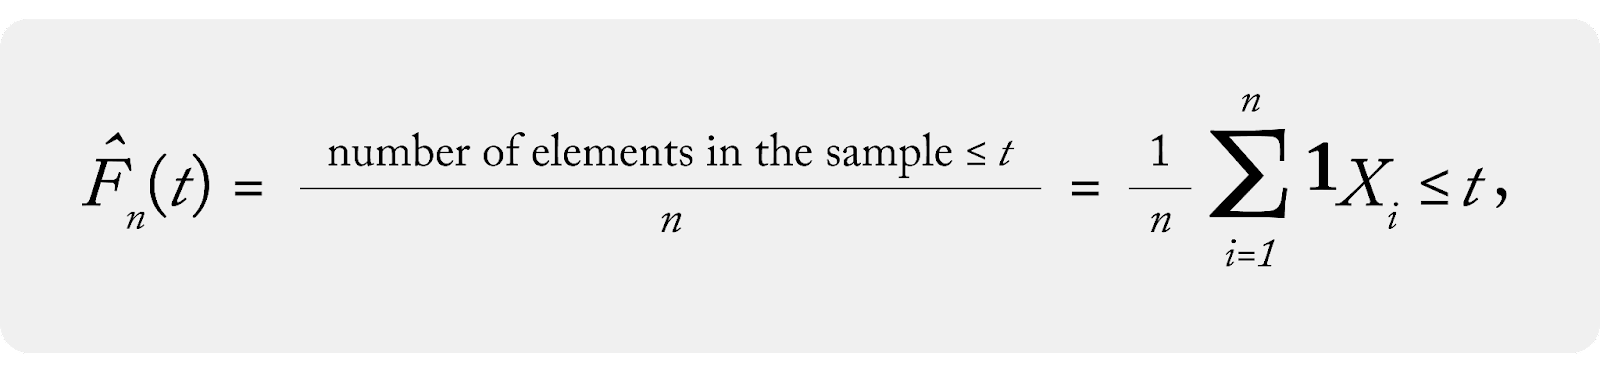

- How Do You Create the Kolmogorov Distribution?
    To create the Kolmogorov distribution:

1. You can bootstrap your data or gather another eCDF
2. Run 500 times to generate 500 eCDFs
3. Calculate the K-S for each eCDF
4. Plot all 500 of the K-S values as a distribution

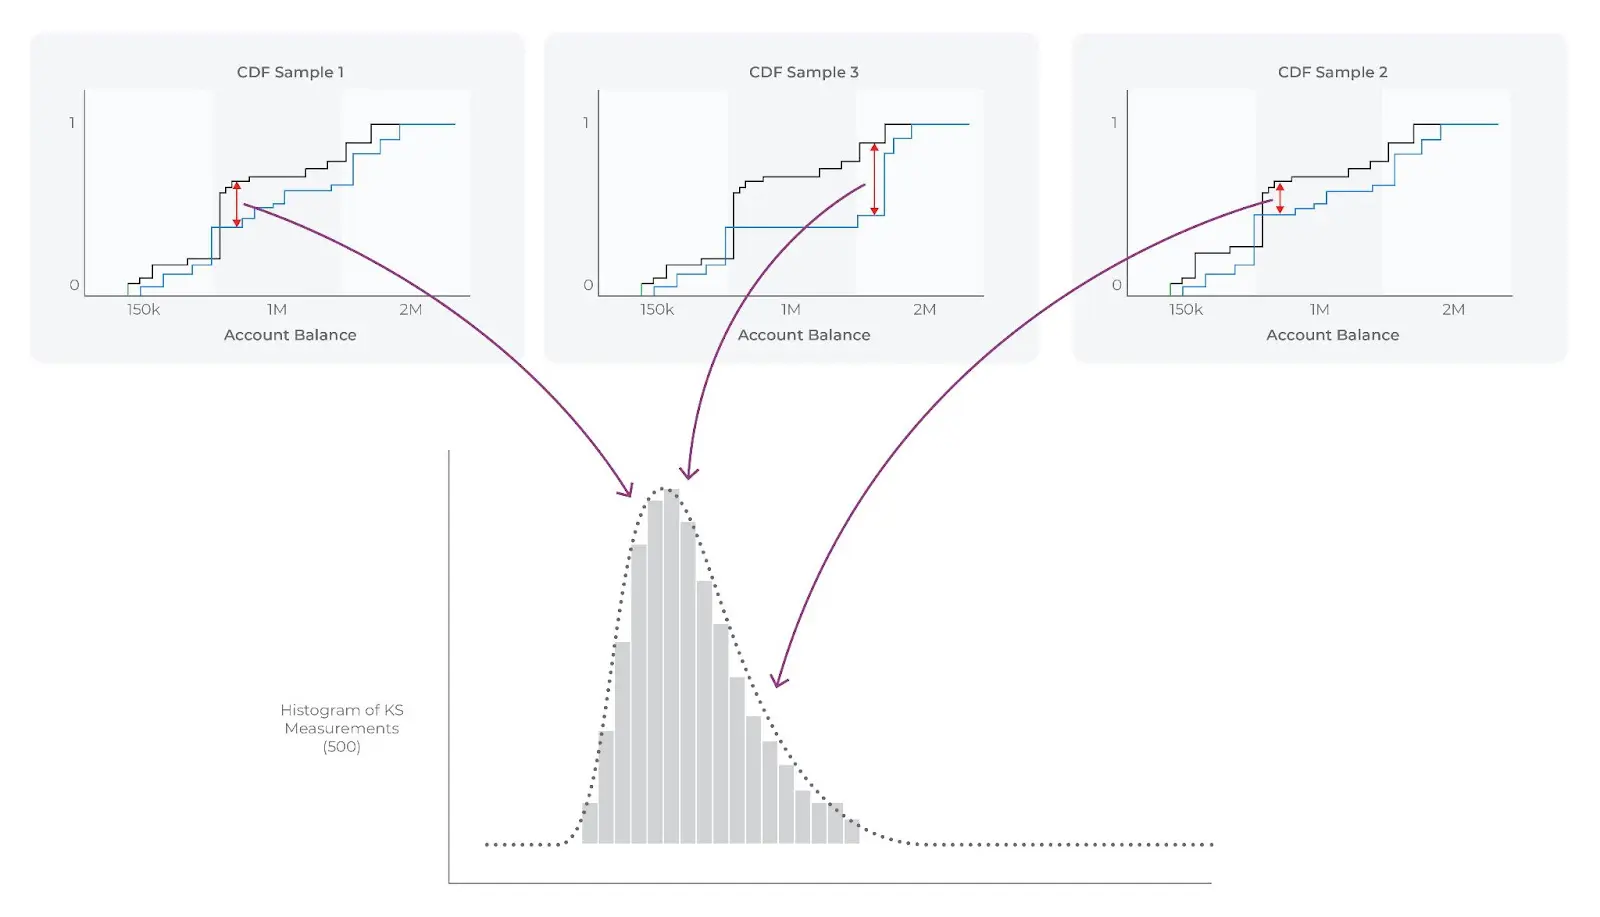

## Mini example in other code...
Code:
- from scipy.stats import ks_2samp
- import numpy as np


- np.random.seed(12345678)
- x = np.random.normal(0, 1, 10000)
- y = np.random.normal(0, 1, 100000)
- z = np.random.normal(1.1, 0.9, 10000)


- print(ks_2samp(x, y))
- print(ks_2samp(x, z))


- KstestResult(statistic=0.008180000000000076, pvalue=0.5742210629027362)
- KstestResult(statistic=0.4332, pvalue=0.0)

Can Kolmogorov Smirnov Test Be Monitored Over Time To Detect Model Drift?
Yes. In typical statistical textbook use of the Kolmogorov Smirnov Test test, it is a static comparison between two A and B distributions. The monitoring use case is distinct from the textbook use of the Kolmogorov Smirnov Test (which would be a static comparison between two A and B distributions) in that data scientists generate eCDFs periodically measuring K-S periodically.

# Code for the team to evaluate transformer with KS:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load training and test data
data_train = pd.read_csv("aapl_5m_train.csv").dropna()
data_test = pd.read_csv("aapl_5m_test.csv").dropna()

train_mean = data_train.loc[:, ["Open", "High", "Low", "Close"]].mean()
train_std = data_train.loc[:, ["Open", "High", "Low", "Close"]].std()

norm_data_train = (data_train.loc[:, ["Open", "High", "Low", "Close"]] - train_mean) / train_std
norm_data_test = (data_test.loc[:, ["Open", "High", "Low", "Close"]] - train_mean) / train_std

lags = 5

X_train = pd.DataFrame()
X_test = pd.DataFrame()

for lag in range(lags):
    X_train[f"Open_{lag}"] = norm_data_train.Open.shift(lag)
    X_train[f"High_{lag}"] = norm_data_train.High.shift(lag)
    X_train[f"Low_{lag}"] = norm_data_train.Low.shift(lag)
    X_train[f"Close_{lag}"] = norm_data_train.Close.shift(lag)
    
    X_test[f"Open_{lag}"] = norm_data_test.Open.shift(lag)
    X_test[f"High_{lag}"] = norm_data_test.High.shift(lag)
    X_test[f"Low_{lag}"] = norm_data_test.Low.shift(lag)
    X_test[f"Close_{lag}"] = norm_data_test.Close.shift(lag)

Y_train = (X_train.Close_0 * (1 + 0.01) < X_train.Close_0.shift(-1)).astype(float)
Y_test = (X_test.Close_0 * (1 + 0.01) < X_test.Close_0.shift(-1)).astype(float)

# Removing nans and last value
X_train = X_train.iloc[5:-1, :].values
X_test = X_test.iloc[5:-1, :].values

Y_train = Y_train.iloc[5:-1].values.reshape(-1, 1)
Y_test = Y_test.iloc[5:-1].values.reshape(-1, 1)

features = X_train.shape[1]

X_train = X_train.reshape(-1, features, 1)
X_test = X_test.reshape(-1, features, 1)

# Combine training and test data but give more weight to test data
X_combined = np.concatenate((X_train, np.tile(X_test, (10, 1, 1))), axis=0)
Y_combined = np.concatenate((Y_train, np.tile(Y_test, (10, 1))), axis=0)

# Load initial model
model = load_model("transformer_classifier.keras")

# Step 2: Define the input shape and create the model
input_shape = X_train.shape[1:]
input_layer = tf.keras.layers.Input(input_shape)

def create_transformer(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    # Stacking layers
    l1 = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    l2 = tf.keras.layers.Dropout(dropout)(l1)
    l3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(l2)
    
    res = l3 + inputs
    
    # Traditional DNN
    l4 = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    l5 = tf.keras.layers.Dropout(dropout)(l4)
    l6 = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(l5)
    l7 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(l6)
    return l7 + res

# Hyperparams
head_size = 256
num_heads = 4
num_transformer_blocks = 4  
ff_dim = 4
units = 128
dropout_rate = 0.3  
learning_rate = 1e-4
batch_size = 35  # Reduce batch size
epochs = 12  # Increase epochs

# Create Transformer layers
transformer_layers = input_layer
for _ in range(num_transformer_blocks):
    transformer_layers = create_transformer(inputs=transformer_layers, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout_rate)

# Pooling and MLP layers
pooling_layer = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(transformer_layers)
l1 = tf.keras.layers.Dense(units=128, activation="leaky_relu")(pooling_layer)
l2 = tf.keras.layers.Dropout(0.3)(l1)
l3 = tf.keras.layers.Dense(units=128, activation="leaky_relu")(l2)
outputs = tf.keras.layers.Dense(units=2, activation="softmax")(l3)

# Create and compile the model
model = tf.keras.Model(inputs=input_layer, outputs=outputs, name="transformers_classification")
metric = tf.keras.metrics.SparseCategoricalAccuracy()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=[metric])

# Train the model with combined data
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_combined, Y_combined, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])
model.save('transformer_classifier_retrained.keras')

# Load the retrained model
model_v2 = load_model("transformer_classifier_retrained.keras")

# Predict on training and test data
y_hat_train = model_v2.predict(X_train)
y_hat_test = model_v2.predict(X_test)

# Evaluate the model on training and test data
model_v2.evaluate(X_train, Y_train)
model_v2.evaluate(X_test, Y_test)

# Backtesting
trading_data = data_test.iloc[5:-1, :].copy()
trading_data["BUY_SIGNAL"] = y_hat_test.argmax(axis=1).astype(bool)

capital = 1_000_000
initial_capital = capital
stop_loss = 0.10
take_profit = 0.10

COM = 0.125 / 100

active_positions = []
portfolio_value = [capital]
buy_signals = []

for i, row in trading_data.iterrows():
    # Close all positions that are above/under tp or sl
    active_pos_copy = active_positions.copy()
    for pos in active_pos_copy:
        if row.Close < pos["stop_loss"]:
            # LOSS
            capital += row.Close * pos["n_shares"] * (1 - COM)
            active_positions.remove(pos)
        if row.Close > pos["take_profit"]:
            # PROFIT
            capital += row.Close * pos["n_shares"] * (1 - COM)
            active_positions.remove(pos)

    # Check if trading signal is True
    if row.BUY_SIGNAL:
        buy_signals.append(i)
        # Determine the number of shares based on available capital
        max_shares = int(capital / (row.Close * (1 + COM)))
        n_shares = max_shares // 10  # Adjusting the number of shares to allow more trades
        if n_shares > 0:
            capital -= row.Close * (1 + COM) * n_shares
            active_positions.append({
                "type": "LONG",
                "bought_at": row.Close,
                "n_shares": n_shares,
                "stop_loss": row.Close * (1 - stop_loss),
                "take_profit": row.Close * (1 + take_profit)
            })
        else:
            print("OUT OF CASH")
    
    # Portfolio value through time
    positions_value = sum([pos["n_shares"] * row.Close for pos in active_positions])
    portfolio_value.append(capital + positions_value)

# Close all positions that are above/under tp or sl
active_pos_copy = active_positions.copy()
for pos in active_pos_copy:
    capital += row.Close * pos["n_shares"] * (1 - COM)
    active_positions.remove(pos)

portfolio_value.append(capital)

# Calculate benchmark portfolio value (passive investment)
portfolio_value_benchmark = data_test.iloc[5:].Close.pct_change().fillna(0).add(1).cumprod().mul(initial_capital).values

# Plot the results
plt.figure(figsize=(14, 7))
plt.title(f"Active={(portfolio_value[-1] / initial_capital - 1)*100}%\n" + 
          f"Passive={(portfolio_value_benchmark[-1] / initial_capital - 1)*100}%")
plt.plot(portfolio_value, label="Active")
plt.plot(portfolio_value_benchmark, label="Passive")
plt.scatter(buy_signals, [portfolio_value[i] for i in buy_signals], marker='^', color='g', label='Buy Signal')
plt.legend()
plt.show()



## Check code ! 

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

### Results

KS Statistic Open: 0.5394525143331208, p-value: 0.0
KS Statistic High: 0.5380533522758825, p-value: 0.0
KS Statistic Low: 0.5412087738724078, p-value: 0.0
KS Statistic Close: 0.5395044072137625, p-value: 0.0


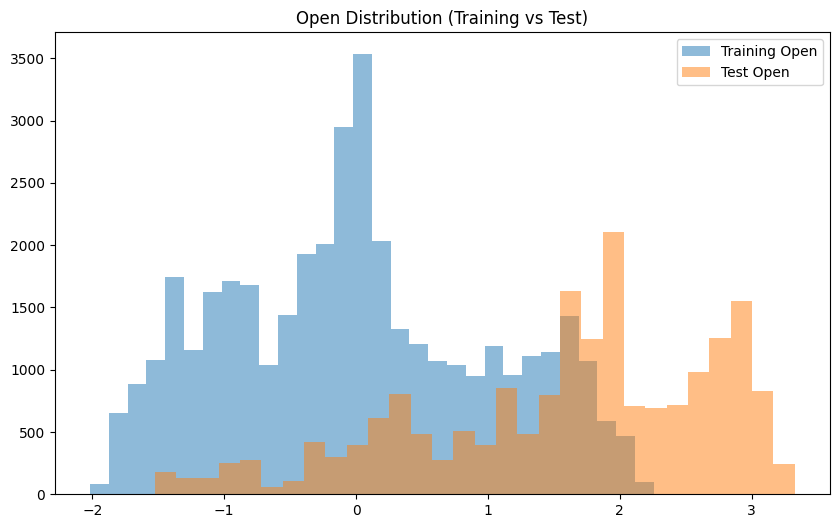

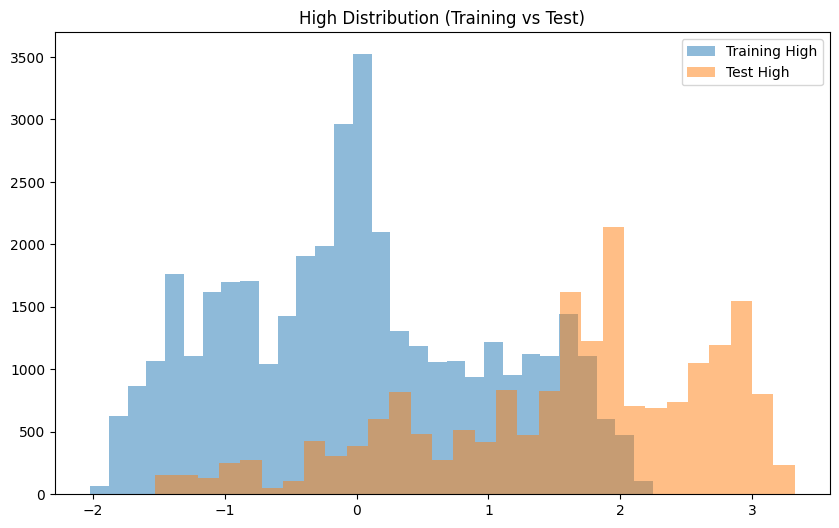

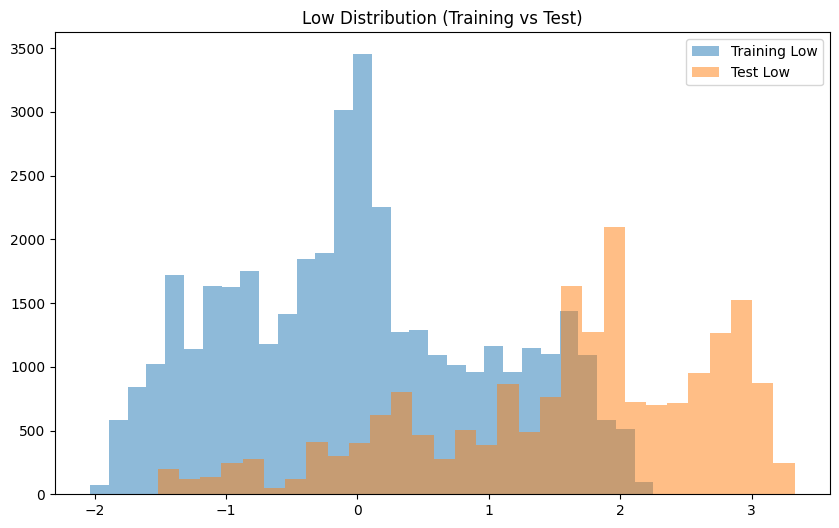

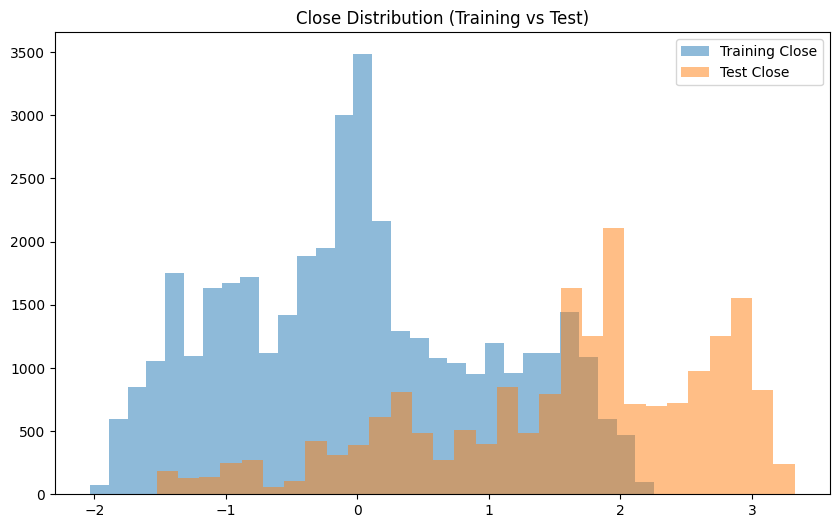

The distributions are significantly different. It is recommended to retrain the model.
Epoch 1/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - loss: 0.5632 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.3750 - val_sparse_categorical_accuracy: 0.8271
Epoch 2/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - loss: 0.5356 - sparse_categorical_accuracy: 0.7295 - val_loss: 0.3717 - val_sparse_categorical_accuracy: 0.8268
Epoch 3/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 0.5347 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.3722 - val_sparse_categorical_accuracy: 0.8267
Epoch 4/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.5319 - sparse_categorical_accuracy: 0.7316 - val_loss: 0.3726 - val_sparse_categorical_accuracy: 0.8268
Epoch 5/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - loss: 0.5350 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.3745 - val_sparse_categorical_accuracy: 0.8272
Epoch 6/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.5373 - sp

In [6]:
# Step 1: Load training and test data
data_train = pd.read_csv("./data/aapl_5m_train.csv").dropna()
data_test = pd.read_csv("./data/aapl_5m_test.csv").dropna()

train_mean = data_train.loc[:, ["Open", "High", "Low", "Close"]].mean()
train_std = data_train.loc[:, ["Open", "High", "Low", "Close"]].std() 

norm_data_train = (data_train.loc[:, ["Open", "High", "Low", "Close"]] - train_mean) / train_std
norm_data_test = (data_test.loc[:, ["Open", "High", "Low", "Close"]] - train_mean) / train_std

lags = 5

X_train = pd.DataFrame()
X_test = pd.DataFrame()

for lag in range(lags):
    X_train[f"Open_{lag}"] = norm_data_train.Open.shift(lag)
    X_train[f"High_{lag}"] = norm_data_train.High.shift(lag)
    X_train[f"Low_{lag}"] = norm_data_train.Low.shift(lag)
    X_train[f"Close_{lag}"] = norm_data_train.Close.shift(lag)
    
    X_test[f"Open_{lag}"] = norm_data_test.Open.shift(lag)
    X_test[f"High_{lag}"] = norm_data_test.High.shift(lag)
    X_test[f"Low_{lag}"] = norm_data_test.Low.shift(lag)
    X_test[f"Close_{lag}"] = norm_data_test.Close.shift(lag)

Y_train = (X_train.Close_0 * (1 + 0.01) < X_train.Close_0.shift(-1)).astype(float)
Y_test = (X_test.Close_0 * (1 + 0.01) < X_test.Close_0.shift(-1)).astype(float)

# Removing nans and last value
X_train = X_train.iloc[5:-1, :].values
X_test = X_test.iloc[5:-1, :].values

Y_train = Y_train.iloc[5:-1].values.reshape(-1, 1)
Y_test = Y_test.iloc[5:-1].values.reshape(-1, 1)

features = X_train.shape[1]

X_train = X_train.reshape(-1, features, 1)
X_test = X_test.reshape(-1, features, 1)

# Define a function to create the Transformer model
def create_transformer(inputs, head_size, num_heads, dnn_dim):
    # Stacking layers
    l1 = tf.keras.layers.MultiHeadAttention(key_dim=head_size,
                                            num_heads=num_heads,
                                            dropout=0.2)(inputs, inputs)
    l2 = tf.keras.layers.Dropout(0.2)(l1)
    l3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(l2)
    
    res = l3 + inputs
    
    # Traditional DNN
    l4 = tf.keras.layers.Conv1D(filters=dnn_dim, kernel_size=1, activation="relu")(res)
    l5 = tf.keras.layers.Dropout(0.2)(l4)
    l6 = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(l5)
    l7 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(l6)
    return l7 + res

# Hyperparams
head_size = 256
num_heads = 4
num_transformer_blocks = 4
dnn_dim = 4
units = 128

# Step 2: Define the input shape and create the model
input_shape = X_train.shape[1:]
input_layer = tf.keras.layers.Input(input_shape)

# Create Transformer layers
transformer_layers = input_layer
for _ in range(num_transformer_blocks):
    transformer_layers = create_transformer(inputs=transformer_layers,
                                            head_size=head_size,
                                            num_heads=num_heads,
                                            dnn_dim=dnn_dim)

# Pooling and MLP layers
pooling_layer = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(transformer_layers)
l1 = tf.keras.layers.Dense(units=128, activation="leaky_relu")(pooling_layer)
l2 = tf.keras.layers.Dropout(0.3)(l1)
l3 = tf.keras.layers.Dense(units=128, activation="leaky_relu")(l2)
outputs = tf.keras.layers.Dense(units=2, activation="softmax")(l3)

# Create and compile the model
model = tf.keras.Model(inputs=input_layer, outputs=outputs, name="transformers_classification")
metric = tf.keras.metrics.SparseCategoricalAccuracy()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=[metric])

# Step 3: Perform the KS test
statistic_open, p_value_open = ks_2samp(norm_data_train['Open'].dropna(), norm_data_test['Open'].dropna())
statistic_high, p_value_high = ks_2samp(norm_data_train['High'].dropna(), norm_data_test['High'].dropna())
statistic_low, p_value_low = ks_2samp(norm_data_train['Low'].dropna(), norm_data_test['Low'].dropna())
statistic_close, p_value_close = ks_2samp(norm_data_train['Close'].dropna(), norm_data_test['Close'].dropna())

print(f'KS Statistic Open: {statistic_open}, p-value: {p_value_open}')
print(f'KS Statistic High: {statistic_high}, p-value: {p_value_high}')
print(f'KS Statistic Low: {statistic_low}, p-value: {p_value_low}')
print(f'KS Statistic Close: {statistic_close}, p-value: {p_value_close}')

# Step 4: Visualize results
plt.figure(figsize=(10, 6))
plt.hist(norm_data_train['Open'].dropna(), bins=30, alpha=0.5, label='Training Open')
plt.hist(norm_data_test['Open'].dropna(), bins=30, alpha=0.5, label='Test Open')
plt.legend(loc='upper right')
plt.title('Open Distribution (Training vs Test)')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(norm_data_train['High'].dropna(), bins=30, alpha=0.5, label='Training High')
plt.hist(norm_data_test['High'].dropna(), bins=30, alpha=0.5, label='Test High')
plt.legend(loc='upper right')
plt.title('High Distribution (Training vs Test)')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(norm_data_train['Low'].dropna(), bins=30, alpha=0.5, label='Training Low')
plt.hist(norm_data_test['Low'].dropna(), bins=30, alpha=0.5, label='Test Low')
plt.legend(loc='upper right')
plt.title('Low Distribution (Training vs Test)')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(norm_data_train['Close'].dropna(), bins=30, alpha=0.5, label='Training Close')
plt.hist(norm_data_test['Close'].dropna(), bins=30, alpha=0.5, label='Test Close')
plt.legend(loc='upper right')
plt.title('Close Distribution (Training vs Test)')
plt.show()

# Step 5: Decide if re-training is needed
if p_value_open < 0.05 or p_value_high < 0.05 or p_value_low < 0.05 or p_value_close < 0.05:
    print("The distributions are significantly different. It is recommended to retrain the model.")
    # Retrain the model with Transformer using new test data
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    combined_X = np.concatenate((X_train, X_test), axis=0)
    combined_Y = np.concatenate((Y_train, Y_test), axis=0)
    model.fit(combined_X, combined_Y, epochs=25, batch_size=64, validation_split=0.4, callbacks=[early_stopping])
    model.save('transformer_classifier_retrained.keras')
else:
    print("The distributions are not significantly different. Retraining the model is not needed.")

1224/1224 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.4908 - sparse_categorical_accuracy: 0.7719
607/607 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4613 - sparse_categorical_accuracy: 0.7798
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF CASH
OUT OF

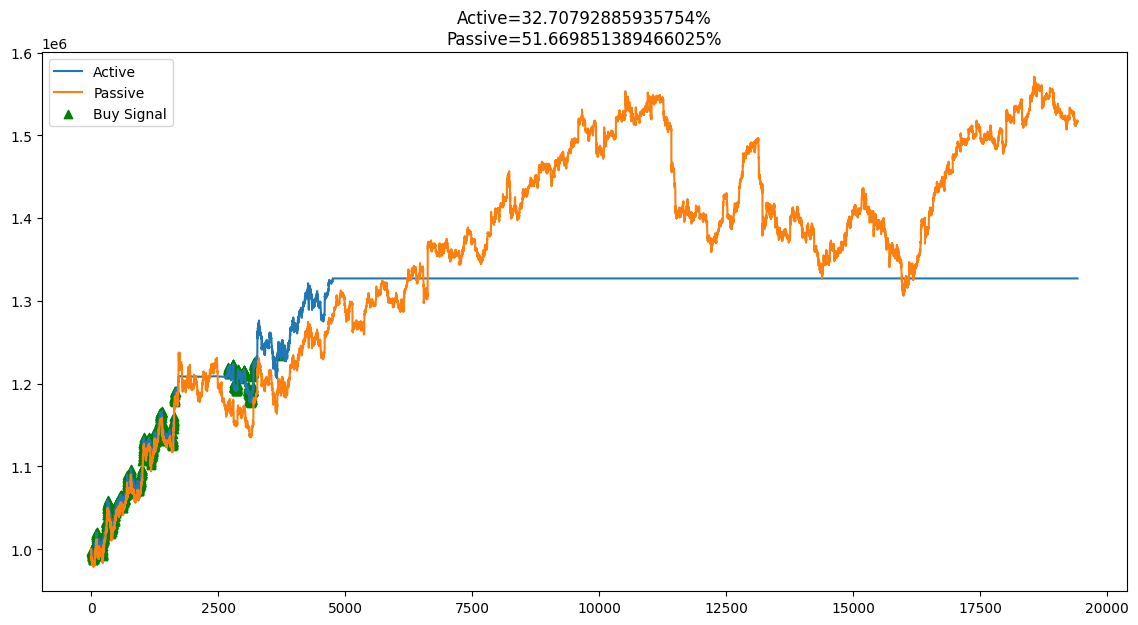

In [7]:
# Load the retrained model
model_v2 = load_model("transformer_classifier_retrained.keras")

# Predict on training and test data
y_hat_train = model_v2.predict(X_train)
y_hat_test = model_v2.predict(X_test)

# Evaluate the model on training and test data
model_v2.evaluate(X_train, Y_train)
model_v2.evaluate(X_test, Y_test)

# Backtesting
trading_data = data_test.iloc[5:-1, :].copy()
trading_data["BUY_SIGNAL"] = y_hat_test.argmax(axis=1).astype(bool)

capital = 1_000_000
initial_capital = capital
stop_loss = 0.10
take_profit = 0.10

COM = 0.125 / 100

active_positions = []
portfolio_value = [capital]
buy_signals = []

for i, row in trading_data.iterrows():
    # Close all positions that are above/under tp or sl
    active_pos_copy = active_positions.copy()
    for pos in active_pos_copy:
        if row.Close < pos["stop_loss"]:
            # LOSS
            capital += row.Close * pos["n_shares"] * (1 - COM)
            active_positions.remove(pos)
        if row.Close > pos["take_profit"]:
            # PROFIT
            capital += row.Close * pos["n_shares"] * (1 - COM)
            active_positions.remove(pos)

    # Check if trading signal is True
    if row.BUY_SIGNAL:
        buy_signals.append(i)
        # Determine the number of shares based on available capital
        max_shares = int(capital / (row.Close * (1 + COM)))
        n_shares = max_shares // 10  # Adjusting the number of shares to allow more trades
        if n_shares > 0:
            capital -= row.Close * (1 + COM) * n_shares
            active_positions.append({
                "type": "LONG",
                "bought_at": row.Close,
                "n_shares": n_shares,
                "stop_loss": row.Close * (1 - stop_loss),
                "take_profit": row.Close * (1 + take_profit)
            })
        else:
            print("OUT OF CASH")
    
    # Portfolio value through time
    positions_value = sum([pos["n_shares"] * row.Close for pos in active_positions])
    portfolio_value.append(capital + positions_value)

# Close all positions that are above/under tp or sl
active_pos_copy = active_positions.copy()
for pos in active_pos_copy:
    capital += row.Close * pos["n_shares"] * (1 - COM)
    active_positions.remove(pos)

portfolio_value.append(capital)

# Calculate benchmark portfolio value (passive investment)
portfolio_value_benchmark = data_test.iloc[5:].Close.pct_change().fillna(0).add(1).cumprod().mul(initial_capital).values

# Plot the results
plt.figure(figsize=(14, 7))
plt.title(f"Active={(portfolio_value[-1] / initial_capital - 1)*100}%\n" + 
          f"Passive={(portfolio_value_benchmark[-1] / initial_capital - 1)*100}%")
plt.plot(portfolio_value, label="Active")
plt.plot(portfolio_value_benchmark, label="Passive")
plt.scatter(buy_signals, [portfolio_value[i] for i in buy_signals], marker='^', color='g', label='Buy Signal')
plt.legend()
plt.show()


# Conclutions

-Juan Antonio Mugica Liparoli: 
### Conclusion

We attempted to retrain the model knowing that the training and test datasets are different. However, we did not achieve the desired solution. It is a very interesting area for predicting future values and correctly training neural networks. We tried retraining the network with the data we learned as our trained neural network encountered the test data. Although we could not reach the solution, I conclude that monitoring is an important area for making effective models in professional practice. Personally, I end up with a project without the desired solution but with the learning of this "monitoring" technique, and I will continue working to find the desired solution. I searched for tutorials and guides on YouTube and internet forums, but it is somewhat confusing and unfamiliar to someone who has not touched on these topics before. With this last project, I realize that I have much to learn before implementing these models professionally.

This project aimed to create a robust trading strategy using a transformer-based model to predict stock price movements. While the model initially performed well, several key insights emerged, emphasizing the importance of continuous monitoring and retraining to adapt to evolving market conditions.

#### Key Points:

1. **Dynamic Financial Markets**:
   - Markets constantly change, making it crucial to monitor data distributions and model performance to keep predictions accurate.

2. **KS Test for Monitoring**:
   - The Kolmogorov-Smirnov test was used to identify significant differences between training and test data distributions, indicating when retraining is necessary.

3. **Weighted Retraining**:
   - The test data was weighted more heavily during retraining, making the model more sensitive to recent market conditions and improving adaptability.

4. **Capital Management**:
   - Dynamic adjustment of share quantities and reinvestment of profits helped manage capital better, ensuring continuous trading activity.

5. **Challenges and Future Steps**:
   - Despite improvements, challenges like running out of capital and decreased buy signal sensitivity remained. Future steps include enhanced feature engineering, advanced model architectures, and robust validation techniques to further refine the strategy.

### Summary

Continuous monitoring, frequent retraining, and strategic capital management are crucial for maintaining an effective trading model. While challenges persist, the insights gained provide a pathway for ongoing refinement and improved performance in dynamic financial markets.